In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "PL_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

# Load Files

In [2]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_PL_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [3]:
len(windmill)

28

In [4]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [5]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [6]:
df = features.parallelize_extract(df)

parallelize_extract time:  1233.274337053299


In [7]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [8]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [9]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [10]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [11]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [12]:
df_train.to_parquet(constant.PL_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.PL_SC_EVL_path, index=False)

# Neural Network Train

In [2]:
df_train = pd.read_parquet(constant.PL_SC_TRAIN_path)

In [3]:
len(df_train)

244636

In [4]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=40
hidden_size = 1000
output_size = 1

## Original Features


In [5]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [6]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.04437666013836861 test loss: 0.03711196407675743
Epoch 10 train loss: 0.024884121492505074 test loss: 0.0233000535517931
Epoch 20 train loss: 0.02401759661734104 test loss: 0.023637065663933754
Epoch 30 train loss: 0.022865820676088333 test loss: 0.023775378242135048
Epoch 39 train loss: 0.021932978183031082 test loss: 0.02418225258588791
Epoch 0 train loss: 0.023479513823986053 test loss: 0.009093123488128185
Epoch 10 train loss: 0.02492830902338028 test loss: 0.013300038874149323
Epoch 20 train loss: 0.023147594183683395 test loss: 0.011541874147951603
Epoch 30 train loss: 0.021952200680971146 test loss: 0.009877149946987629
Epoch 39 train loss: 0.021180259063839912 test loss: 0.008976968936622143
Epoch 0 train loss: 0.020683307200670242 test loss: 0.012845881283283234
Epoch 10 train loss: 0.02074415422976017 test loss: 0.014709512703120708
Epoch 20 train loss: 0.019927524030208588 test loss: 0.014262055978178978
Epoch 30 train loss: 0.01901131682097912 test los

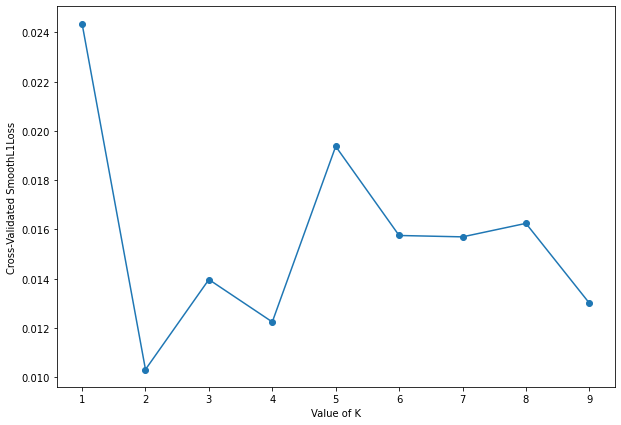

In [7]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [17]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [18]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"original_model.pth")

Epoch 0 train loss: 0.03934895247220993
Epoch 10 train loss: 0.02383606508374214
Epoch 20 train loss: 0.023703794926404953
Epoch 30 train loss: 0.02265622280538082


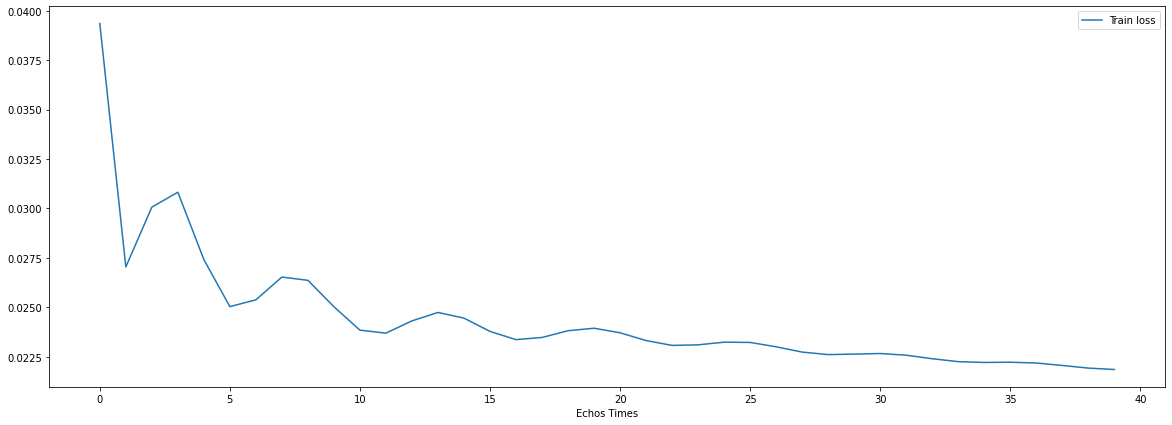

In [32]:
myplot.model_loss({"Train loss":train_hist_original}, path=plot_path+"original_loss.png")

## Windshear Features

In [9]:
model_wsr = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [10]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.031237393617630005 test loss: 0.02666010707616806
Epoch 10 train loss: 0.009114190004765987 test loss: 0.008623930625617504
Epoch 20 train loss: 0.008586813695728779 test loss: 0.007603887468576431
Epoch 30 train loss: 0.007820136845111847 test loss: 0.006974174175411463
Epoch 39 train loss: 0.007522714789956808 test loss: 0.006912681274116039
Epoch 0 train loss: 0.007801223546266556 test loss: 0.004259450826793909
Epoch 10 train loss: 0.007780257612466812 test loss: 0.004236836452037096
Epoch 20 train loss: 0.007751139346510172 test loss: 0.004156298004090786
Epoch 30 train loss: 0.0076186624355614185 test loss: 0.004113690461963415
Epoch 39 train loss: 0.0074987453408539295 test loss: 0.0040592774748802185
Epoch 0 train loss: 0.007287360727787018 test loss: 0.005645948927849531
Epoch 10 train loss: 0.008996278047561646 test loss: 0.006583009846508503
Epoch 20 train loss: 0.007264532148838043 test loss: 0.005662587005645037
Epoch 30 train loss: 0.0073556220158934

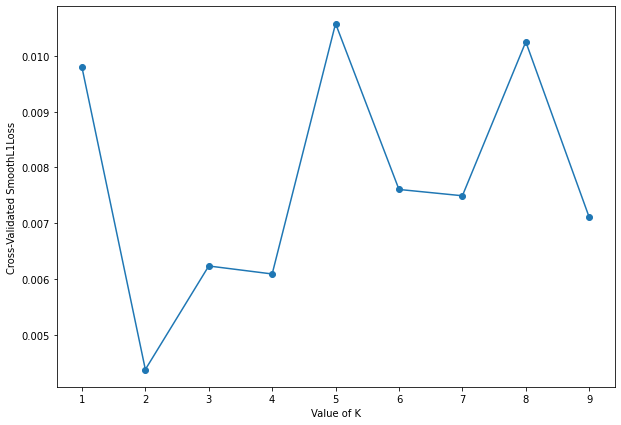

In [11]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [34]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [35]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"wsr_model.pth")

Epoch 0 train loss: 0.02840595506131649
Epoch 10 train loss: 0.008807317353785038
Epoch 20 train loss: 0.008424206636846066
Epoch 30 train loss: 0.007689155172556639


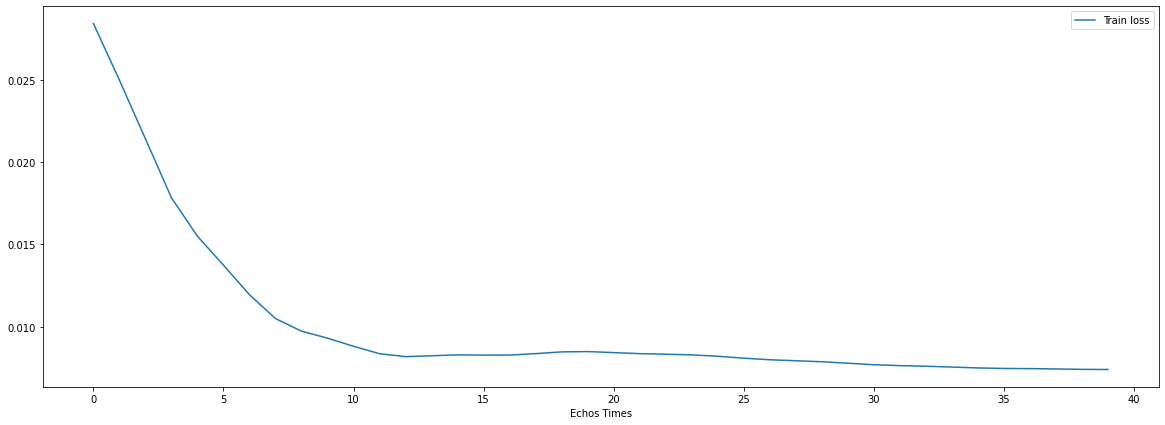

In [36]:
myplot.model_loss({"Train loss":train_hist_wsr}, path=plot_path+"wsr_loss.png")

## Geo Features

In [12]:
model_geo = MLP_Regression(
  input_size=49,
  hidden_size=hidden_size
)

In [13]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03816182538866997 test loss: 0.029247868806123734
Epoch 10 train loss: 0.010657617822289467 test loss: 0.010477672331035137
Epoch 20 train loss: 0.00863528624176979 test loss: 0.008708862587809563
Epoch 30 train loss: 0.007971898652613163 test loss: 0.007192350924015045
Epoch 39 train loss: 0.007554455194622278 test loss: 0.006824583746492863
Epoch 0 train loss: 0.007782487198710442 test loss: 0.004334018100053072
Epoch 10 train loss: 0.008156973868608475 test loss: 0.00456974795088172
Epoch 20 train loss: 0.007552006747573614 test loss: 0.004189320839941502
Epoch 30 train loss: 0.007428037468343973 test loss: 0.004057673737406731
Epoch 39 train loss: 0.007354422006756067 test loss: 0.004029939882457256
Epoch 0 train loss: 0.007218874059617519 test loss: 0.005443538073450327
Epoch 10 train loss: 0.00900185015052557 test loss: 0.006576880346983671
Epoch 20 train loss: 0.007178066298365593 test loss: 0.005411174613982439
Epoch 30 train loss: 0.007238279562443495 tes

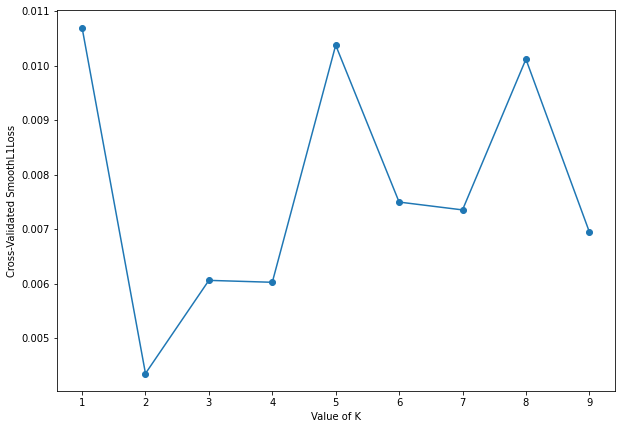

In [14]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [38]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [39]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.042740676552057266
Epoch 10 train loss: 0.011356540024280548
Epoch 20 train loss: 0.008437316864728928
Epoch 30 train loss: 0.00785174872726202


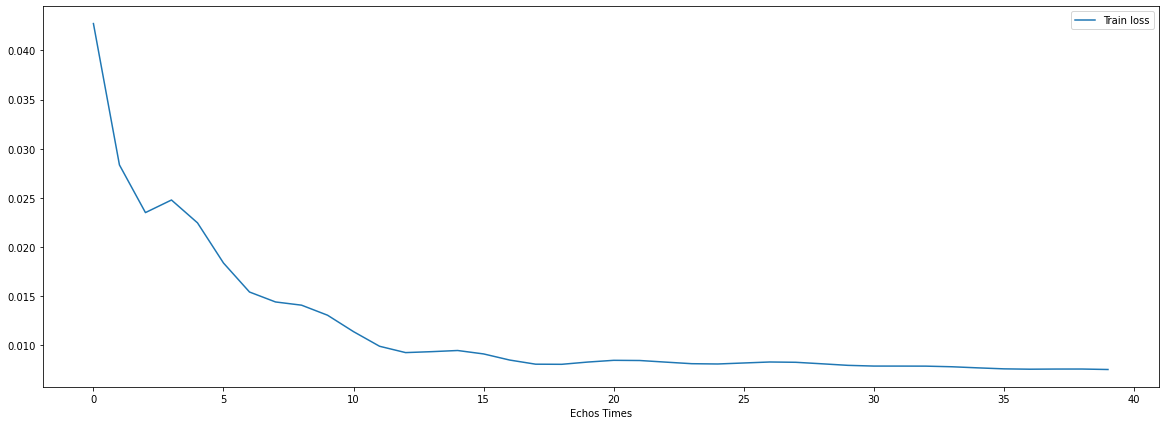

In [40]:
myplot.model_loss({"Train loss":train_hist_geo}, path=plot_path+"geo_loss.png")

## Semigeo Features

In [15]:
model_semigeo = MLP_Regression(
  input_size=50,
  hidden_size=1000
)

In [16]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03451782464981079 test loss: 0.03021259233355522
Epoch 10 train loss: 0.010678451508283615 test loss: 0.010664498433470726
Epoch 20 train loss: 0.008340250700712204 test loss: 0.008370080962777138
Epoch 30 train loss: 0.007769000716507435 test loss: 0.007057543378323317
Epoch 39 train loss: 0.007367522921413183 test loss: 0.006778434384614229
Epoch 0 train loss: 0.007639593910425901 test loss: 0.004303568508476019
Epoch 10 train loss: 0.0078011504374444485 test loss: 0.0043469988740980625
Epoch 20 train loss: 0.007502555847167969 test loss: 0.004119310528039932
Epoch 30 train loss: 0.007308977656066418 test loss: 0.0040160794742405415
Epoch 39 train loss: 0.007205338682979345 test loss: 0.003980859182775021
Epoch 0 train loss: 0.007019823882728815 test loss: 0.005272764712572098
Epoch 10 train loss: 0.007741115055978298 test loss: 0.0056177545338869095
Epoch 20 train loss: 0.00737485196441412 test loss: 0.005452733486890793
Epoch 30 train loss: 0.00701216002926230

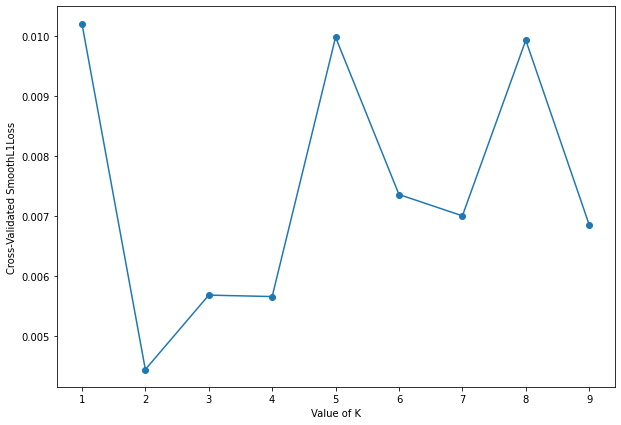

In [17]:
myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [42]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [43]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.03714055195450783
Epoch 10 train loss: 0.011155416257679462
Epoch 20 train loss: 0.008391006849706173
Epoch 30 train loss: 0.007788195740431547


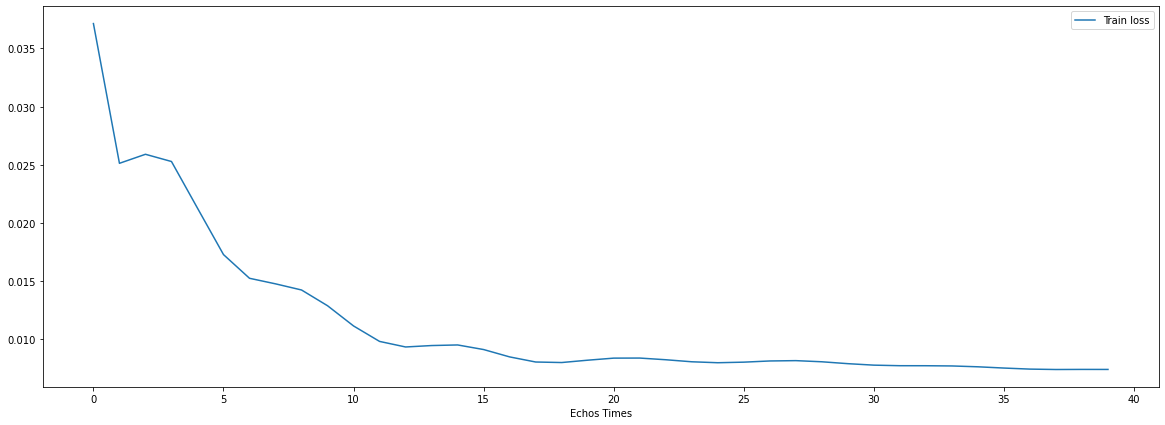

In [44]:
myplot.model_loss({"Train loss":train_hist_semigeo}, path=plot_path+"semigeo_loss.png")